In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import time

In [2]:
device='cpu'

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 15 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

Xtr = Xtr.to(device)
Ytr = Ytr.to(device)

Xdev = Xdev.to(device)
Ydev = Ydev.to(device)

Xte = Xte.to(device)
Yte = Yte.to(device)

torch.Size([182625, 15]) torch.Size([182625])
torch.Size([22655, 15]) torch.Size([22655])
torch.Size([22866, 15]) torch.Size([22866])


In [7]:
Ytr.device

device(type='cpu')

In [10]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trainable via backprop)
    self.gamma = torch.ones(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    self.beta = torch.zeros(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    # Buffers (updated via momentum)
    self.running_mean = torch.zeros(dim, device=device)  # Shape [C]
    self.running_var = torch.ones(dim, device=device)    # Shape [C]
  
  def __call__(self, x):
    if self.training:
      # Compute mean and variance across batch and sequence length (dim=(0,2))
      xmean = x.mean(dim=(0, 2), keepdim=True)  # Shape [1, C, 1]
      xvar = x.var(dim=(0, 2), keepdim=True)    # Shape [1, C, 1]
    else:
      # Use running statistics for inference
      xmean = self.running_mean.view(1, -1, 1)  # Shape [1, C, 1]
      xvar = self.running_var.view(1, -1, 1)    # Shape [1, C, 1]
    
    # Normalize input
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta         # Scale and shift

    # Update running statistics during training
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze()
    
    return self.out
  
  def parameters(self):
    # Return trainable parameters
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim), device=device)
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel), device=device) * ((2 / (in_channels * kernel)) ** 0.5)
        self.bias = torch.randn(out_channels, device=device) * 0
        self.effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        self.Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        # effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert self.effective_kernel <= L
            
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, self.effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        # Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, self.Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

class Residual: 
    def __init__(self, layers):
        self.projection_needed = False
        self.layers = layers
        
        
        # Input of the in layer config
        in_layer = layers[0]
        out_layer = layers[-1]

        self.in_channels = in_layer.in_channels
        self.in_sequence_length = in_layer.sequence_length

        self.out_channels = out_layer.out_channels
        self.out_sequence_length = out_layer.Lout

        if self.in_channels != self.out_channels: # Assuming for now, this will always be the case
            self.projection_needed = True
            self.linear_projection_conv = Conv1d(sequence_length=self.in_sequence_length, out_channels=self.out_channels, in_channels=self.in_channels, kernel=1)
            
    def __call__(self, x):
        self.input = x
        for layer in self.layers: 
            x = layer(x)
        # Perform residual operation
        if self.projection_needed:
            linear_projection = self.linear_projection_conv(self.input)
            
        # Pad the output since the Lout != Lin
        sequence_length_diff = self.in_sequence_length - self.out_sequence_length
        x = F.pad(x, (sequence_length_diff // 2, sequence_length_diff - sequence_length_diff // 2))
        
        self.out = x + linear_projection if self.projection_needed else x + self.input
        
        return self.out
        
    def parameters(self):
        # Collect parameters from all layers and the projection (if used)
        params = [p for layer in self.layers for p in layer.parameters()]
        if self.projection_needed:
            params += self.linear_projection_conv.parameters()
        return params

class ElmanRNN:
    def __init__(self, input_channels, hidden_channels): # Bias would be present. Tanh non linearity will be applied. 
        self.wxh = torch.randn((input_channels, hidden_channels), device=device) * (5/3 / (input_channels) ** 0.5)
        self.bxh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.whh = torch.randn((hidden_channels, hidden_channels), device=device) * (5/3 / (hidden_channels) ** 0.5)
        self.bhh = torch.randn((1, hidden_channels), device=device) * 0.001
        
        self.hidden_channels = hidden_channels
        self.input_channels = input_channels

    def __call__(self, x):
        N, C, L = x.shape

        # Iterate over the entire sequence length and generate logits. The shape of the output logits will be [N, Hout, L]
        logits = torch.zeros((N, self.hidden_channels, L), device=device)
        H = torch.zeros((N, self.hidden_channels), device=device)
        for i in range(L):
            xi = x[:, :, i]
            xih = (xi @ self.wxh) + self.bxh
            hh = (H @ self.whh) + self.bhh
            ht = torch.tanh(xih + hh)
            
            H = ht 
            logits[:, :, i] = ht
            self.out = logits
            
        return self.out

    def parameters(self):
        return [self.wxh] + [self.whh] + [self.bxh] + [self.bhh]



### Recurrent Neural Nets 
Instead of passing the entire sequence as a single input, we pass one character at a time. 
each character creates a hidden state of its own. But the hidden state of a character is also a function of the hidden state of the previous character. 
This enables the RNNs to build the next output, not just on specific localisations of the input, but the entire time series of the sequence. 

In [9]:
n_embeddings = 24
h_channels = 120
h2_channels = 60
h3_channels = 60
h4_channels = 80
h5_channels = 100
h6_channels = 120
model = Sequential([
    Embedding(vocab_size, n_embeddings),
    ElmanRNN(n_embeddings, h_channels),
    ElmanRNN(h_channels, h2_channels),
    ElmanRNN(h2_channels, h3_channels),
    ElmanRNN(h3_channels, h4_channels),
    ElmanRNN(h4_channels, h5_channels),
    ElmanRNN(h5_channels, h6_channels),
    Flatten(), Linear(h6_channels * block_size, vocab_size)
])
# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
        p.requires_grad = True

parameters: 141235


In [521]:
lossi = []

In [522]:
start_time = time.time_ns()
max_steps = 100000
for i in range(max_steps): 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 
    
    # Forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward 
    for p in model.parameters():
        p.grad = None
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update the parameters 
    e = 0.001 if i < 5000 else 0.0005
    for p in model.parameters():
        p.data += -0.1 * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
end_time = time.time_ns() 
print(f"Total time: {(end_time - start_time) / 1_000_000_000}")

      0/ 100000: 3.7010
   1000/ 100000: 3.0973
   2000/ 100000: 2.7753
   3000/ 100000: 2.7046
   4000/ 100000: 2.2872
   5000/ 100000: 2.5552
   6000/ 100000: 2.6025
   7000/ 100000: 2.8151
   8000/ 100000: 2.7658
   9000/ 100000: 2.5638
  10000/ 100000: 2.2385
  11000/ 100000: 2.1548
  12000/ 100000: 2.2002
  13000/ 100000: 2.6872
  14000/ 100000: 2.4253
  15000/ 100000: 2.1521
  16000/ 100000: 2.1424
  17000/ 100000: 2.2963
  18000/ 100000: 2.0958
  19000/ 100000: 2.7157
  20000/ 100000: 2.4237
  21000/ 100000: 2.4928
  22000/ 100000: 1.8205
  23000/ 100000: 2.3989
  24000/ 100000: 2.2293
  25000/ 100000: 2.1902
  26000/ 100000: 1.9902
  27000/ 100000: 2.5287
  28000/ 100000: 2.2691
  29000/ 100000: 2.4413
  30000/ 100000: 2.3797
  31000/ 100000: 2.2396
  32000/ 100000: 1.9454
  33000/ 100000: 2.2365
  34000/ 100000: 2.3998
  35000/ 100000: 1.8863
  36000/ 100000: 1.9341
  37000/ 100000: 1.6442
  38000/ 100000: 2.2832
  39000/ 100000: 1.7940
  40000/ 100000: 1.9087
  41000/ 100000:

### Important Note:
Increasing the hidden layer channels beyond a certain value, the loss actually gets worse, goes all the way to 10. This could be because of the exploding/vanishing gradients.

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [524]:
for layer in model.layers:
    layer.training = False
    
split_loss('train')
split_loss('val')

train 1.8942958116531372
val 2.0800225734710693


In [25]:
def sample_from_model():
    res = []
    for _ in range(20):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
          # forward pass the neural net
          logits = model(torch.tensor([context]))
          probs = F.softmax(logits, dim=1)
          # sample from the distribution
          ix = torch.multinomial(probs, num_samples=1).item()
          # shift the context window and track the samples
          context = context[1:] + [ix]
          out.append(ix)
          # if we sample the special '.' token, break
          if ix == 0:
            break
        res.append(''.join(itos[i] for i in out)) # decode and print the generated word
    return res

In [526]:
sample_from_model()

['rydley.',
 'jubia.',
 'arjan.',
 'gear.',
 'diva.',
 'naili.',
 'kian.',
 'tybian.',
 'leandra.',
 'avannah.',
 'zahmar.',
 'wallen.',
 'gwencia.',
 'meytia.',
 'shasty.',
 'colese.',
 'kristie.',
 'tavin.',
 'symver.',
 'jeancis.']

In [527]:
lossi = torch.tensor(lossi)


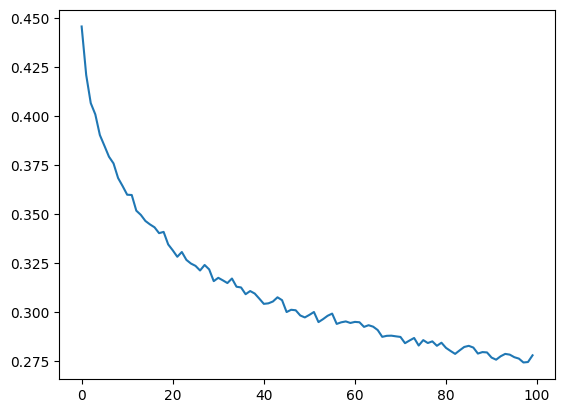

In [528]:
plt.plot(lossi.view(-1, 1000).mean(1))

(array([623., 100.,  56.,  39.,  28.,  35.,  39.,  61., 104., 715.]),
 array([-1.00000000e+00, -8.00000072e-01, -6.00000143e-01, -4.00000215e-01,
        -2.00000286e-01, -3.57627869e-07,  1.99999571e-01,  3.99999499e-01,
         5.99999428e-01,  7.99999356e-01,  9.99999285e-01]),
 <BarContainer object of 10 artists>)

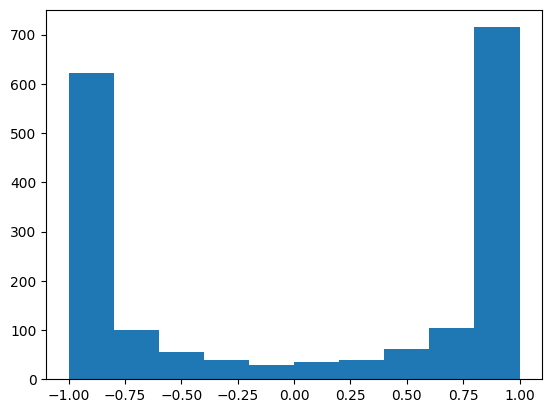

In [519]:
plt.hist(model.layers[1].out.clone().detach().view(-1));


### Long-Short Term Memory

In [16]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define gate weights 
        # Input Gate weights
        self. wii = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.whi = torch.randn((hidden_size, hidden_size)) / (hidden_size ** 0.5)
        self.bii = torch.randn(hidden_size) * 0.001
        
        # Forget Gate weights 
        self.wif = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.whf = torch.randn((hidden_size, hidden_size)) / (input_size ** 0.5)
        self.bif = torch.randn(hidden_size) * 0.001

        # Cell candidiate weights 
        self.wig = torch.randn((input_size, hidden_size)) * ((5/3) / (input_size ** 0.5))
        self.whg = torch.randn((hidden_size, hidden_size)) * ((5/3) / (input_size ** 0.5))
        self.big = torch.randn(hidden_size) * 0.001
        # Output gate weights 
        self.wio = torch.randn((input_size, hidden_size)) / (input_size ** 0.5)
        self.who = torch.randn((hidden_size, hidden_size)) / (hidden_size ** 0.5)
        self.bio = torch.randn(hidden_size) * 0.001

    def __call__(self, x, H=None, C=None):
        # Shape of x will be [N, C, L]. N = batch size, C = input channel size, L = input sequence length 
        N, I, L = x.shape 
        if H == None:
            H = torch.zeros((N, self.hidden_size))
        if C == None: 
            C = torch.zeros((N, self.hidden_size))
        logits = torch.zeros((N, self.hidden_size, L))
        for i in range(x.shape[2]):
            xi = x[:, :, i]
            # Compute gate vectors 
            it = torch.sigmoid((xi @ self.wii) + (H @ self.whi) + self.bii)
            ft = torch.sigmoid((xi @ self.wif) + (H @ self.whf) + self.bif)
            gt = torch.tanh((xi @ self.wig) + (H @ self.whg) + self.big)
            ot = torch.sigmoid((xi @ self.wio) + (H @ self.who) + self.bio)
            ct = (ft * C) + (it * gt)
            C = ct
            ht = ot * torch.tanh(ct)
            H = ht
            logits[:, :, i] = ht
        self.out = logits
        self.C = C
        return self.out, self.C
    def parameters(self):
        return [self.wii, self.whi, self.bii] + [self.wif, self.whf, self.bif] + [self.wig, self.whg, self.big] + [self.wio, self.who, self.bio]

class LayeredLSTM:
    def __init__(self, layers):
        self.layers = layers


    def __call__(self, x, h=None, c=None):
        N, I, L = x.shape  # N=batch size, I=input channels, L=sequence length

        if h is None:
            h = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]
        if c is None:
            c = [torch.zeros((N, layer.hidden_size)) for layer in self.layers]

        for i, layer in enumerate(self.layers):
            x, cell_state = layer(x, h[i], c[i])
            h[i] = x[:, :, -1]
            c[i] = cell_state
        
        return x
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]


In [588]:
n_embeddings = 24
h_channels = 120
model = Sequential([
    Embedding(vocab_size, n_embeddings),
    LSTM(n_embeddings, h_channels),
    Flatten(), Linear(h_channels, vocab_size)
])
# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
        p.requires_grad = True

parameters: 73515


In [589]:
lossi = []

In [590]:
start_time = time.time_ns()
max_steps = 100000
for i in range(max_steps): 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 
    
    # Forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward 
    for p in model.parameters():
        p.grad = None
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update the parameters 
    e = 0.001 if i < 5000 else 0.0005
    for p in model.parameters():
        p.data += -0.1 * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
end_time = time.time_ns() 
print(f"Total time: {(end_time - start_time) / 1_000_000_000}")

      0/ 100000: 3.3662
   1000/ 100000: 3.0175
   2000/ 100000: 2.8309
   3000/ 100000: 2.7810
   4000/ 100000: 2.7401
   5000/ 100000: 2.6225
   6000/ 100000: 2.6869
   7000/ 100000: 2.6830
   8000/ 100000: 2.8185
   9000/ 100000: 2.8013
  10000/ 100000: 1.9832
  11000/ 100000: 2.2383
  12000/ 100000: 2.6652
  13000/ 100000: 2.5085
  14000/ 100000: 2.1977
  15000/ 100000: 2.1921
  16000/ 100000: 2.3635
  17000/ 100000: 2.0285
  18000/ 100000: 2.8960
  19000/ 100000: 2.4472
  20000/ 100000: 2.0105
  21000/ 100000: 2.2377
  22000/ 100000: 2.1830
  23000/ 100000: 1.9762
  24000/ 100000: 2.2043
  25000/ 100000: 2.1222
  26000/ 100000: 2.3407
  27000/ 100000: 1.8874
  28000/ 100000: 2.4812
  29000/ 100000: 2.3148
  30000/ 100000: 1.9913
  31000/ 100000: 2.1941
  32000/ 100000: 2.1680
  33000/ 100000: 2.4322
  34000/ 100000: 2.2261
  35000/ 100000: 2.1541
  36000/ 100000: 2.2270
  37000/ 100000: 2.2516
  38000/ 100000: 2.0072
  39000/ 100000: 2.2620
  40000/ 100000: 2.5012
  41000/ 100000:

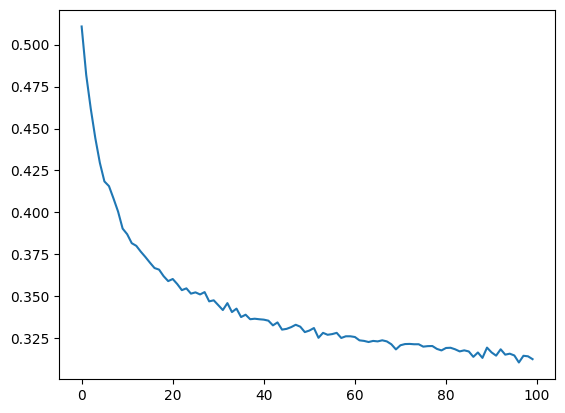

In [591]:
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1))

In [592]:
for layer in model.layers:
    layer.training = False
    
split_loss('train')
split_loss('val')

train 2.065868854522705
val 2.128507137298584


In [593]:
sample_from_model()

['luci.',
 'arvan.',
 'asven.',
 'cannier.',
 'samzenuela.',
 'leomarlys.',
 'garase.',
 'ardies.',
 'cailyn.',
 'abakagani.',
 'deannat.',
 'shani.',
 'amrricce.',
 'aydieel.',
 'shamiyah.',
 'aniz.',
 'arma.',
 'gailee.',
 'khyarion.',
 'styshau.']

In [28]:
n_embeddings = 24
h1_channels = 120
h2_channels = 240
h3_channels = 300
model = Sequential([
    Embedding(vocab_size, n_embeddings),
    LayeredLSTM([
        LSTM(n_embeddings, h1_channels),
        LSTM(h1_channels, h2_channels),
        LSTM(h2_channels, h3_channels)
    ]),
    Flatten(), Linear(h3_channels * block_size, vocab_size)
])
# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
        p.requires_grad = True

parameters: 1187535


In [35]:
lossi = [] 
# lossi = lossi.tolist()

In [36]:
batch_size = 32
start_time = time.time_ns()
max_steps = 100000
for i in range(max_steps): 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 
    
    # Forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward 
    for p in model.parameters():
        p.grad = None
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update the parameters 
    e = 0.001 if i < 70000 else 0.0005
    for p in model.parameters():
        p.data += -e * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
end_time = time.time_ns() 
print(f"Total time: {(end_time - start_time) / 1_000_000_000}")

      0/ 100000: 2.2291
   1000/ 100000: 2.3536
   2000/ 100000: 2.1745
   3000/ 100000: 2.4119
   4000/ 100000: 2.0106
   5000/ 100000: 2.5980
   6000/ 100000: 2.6865
   7000/ 100000: 2.2521
   8000/ 100000: 2.1398
   9000/ 100000: 2.3306
  10000/ 100000: 2.4260
  11000/ 100000: 2.1287
  12000/ 100000: 2.5876
  13000/ 100000: 2.5235
  14000/ 100000: 2.0943
  15000/ 100000: 2.7098
  16000/ 100000: 1.8956
  17000/ 100000: 2.4554
  18000/ 100000: 2.4753
  19000/ 100000: 2.4036
  20000/ 100000: 2.2230
  21000/ 100000: 2.0642
  22000/ 100000: 2.3662
  23000/ 100000: 2.3416
  24000/ 100000: 1.9345
  25000/ 100000: 1.8152
  26000/ 100000: 2.2159
  27000/ 100000: 2.6531
  28000/ 100000: 2.5867
  29000/ 100000: 2.2352
  30000/ 100000: 2.1985
  31000/ 100000: 2.1673
  32000/ 100000: 2.6612
  33000/ 100000: 2.1661
  34000/ 100000: 2.3567
  35000/ 100000: 2.0287
  36000/ 100000: 2.5782
  37000/ 100000: 1.9816
  38000/ 100000: 1.8977
  39000/ 100000: 1.9259
  40000/ 100000: 2.3481
  41000/ 100000:

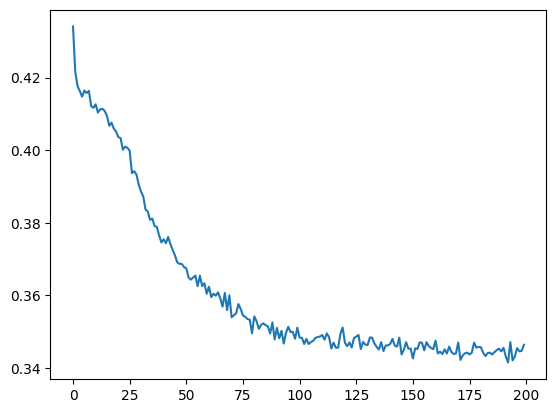

In [37]:
lossi = torch.tensor(lossi)
plt.plot(lossi.view(-1, 1000).mean(1))

In [38]:
for layer in model.layers:
    layer.training = False
    
split_loss('train')
split_loss('val')

train 2.220895290374756
val 2.2240054607391357


In [40]:
sample_from_model()

['fhlio.',
 'alelaen.',
 'raelyn.',
 'dheoley.',
 'ryana.',
 'elag.',
 'wonlo.',
 'kawlyn.',
 'enlaeih.',
 'faizanu.',
 'cdy.',
 'malay.',
 'chobdhieho.',
 'anlayna.',
 'dusson.',
 'jaijan.',
 'alreo.',
 'doity.',
 'nyaly.',
 'auliiahnsaa.']